# **Notes**

- 10000 entries -> no missing values
- 14 columns: 9 int, 2 float, 3 object
- ``'RowNumber'`` ``'CustomerId'`` ``'Surname'`` and ``'Gender'`` are useless columns
- 80/20 target repartition -> not imbalanced
- Need to scale data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.preprocessing import LabelEncoder
 
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = pd.read_csv('customer-churn/Churn_Data.csv')
data.info()
data.isnull().sum()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# We are going to drop the columns that are not useful for our analysis
df_churn = data.copy()
df_churn.drop(['Surname'],axis=1,inplace=True)
df_churn.drop(['Gender'],axis=1,inplace=True)
df_churn.drop(['RowNumber'],axis=1,inplace=True)
df_churn.drop(['CustomerId'],axis=1,inplace=True)
df_churn.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [4]:
palette={"Germany": "#F0E100", "France": "#01295F", "Spain": "#F17105"}
palette_df=pd.DataFrame(palette.items(), columns=['Geography', 'Color'])
palette_df
customersa=pd.DataFrame(df_churn['Geography'].value_counts(normalize=False))
customersa=customersa.reset_index().rename(columns = {'index':'Geography','Geography':'Count'})

customers=pd.merge(customersa, palette_df, on=['Geography'],how='outer')

fig = go.Figure(data=[go.Pie(labels=customers['Geography'], values=customers['Count'],textinfo='label',
                     name='Customers Geographical Locations', 
                     marker_colors=customers['Color'],hole=0.5)])
fig.show()

# Churners and Non-Churners based on their country
churners=df_churn[df_churn['Exited']==1]
nonchurners=df_churn[df_churn['Exited']==0]

churners_counta=pd.DataFrame(churners['Geography'].value_counts(normalize=False))
churners_counta=churners_counta.reset_index().rename(columns = {'index':'Geography','Geography':'Count'})
churners_count=pd.merge(churners_counta, palette_df, on=['Geography'],how='outer')

nonchurners_counta=pd.DataFrame(nonchurners['Geography'].value_counts(normalize=False))
nonchurners_counta=nonchurners_counta.reset_index().rename(columns = {'index':'Geography','Geography':'Count'})
nonchurners_count=pd.merge(nonchurners_counta, palette_df, on=['Geography'],how='outer')

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{"type": "pie"},{"type": "pie"}]],
                    subplot_titles=("Churners by Location","Non-churners by Location"))

fig.add_trace(go.Pie(labels=churners_count['Geography'], values=churners_count['Count'],textinfo='label',
                     name='Churners Geographical Locations', 
                     marker_colors=churners_count['Color'],hole=0.5),1,1)

fig.add_trace(go.Pie(labels=nonchurners_count['Geography'], values=nonchurners_count['Count'],textinfo='label',
                     name='Non-Churners Geographical Locations',  
                     marker_colors=nonchurners_count['Color'],hole=0.5),1,2)

,Exited,Count
0,0,7963
1,1,2037


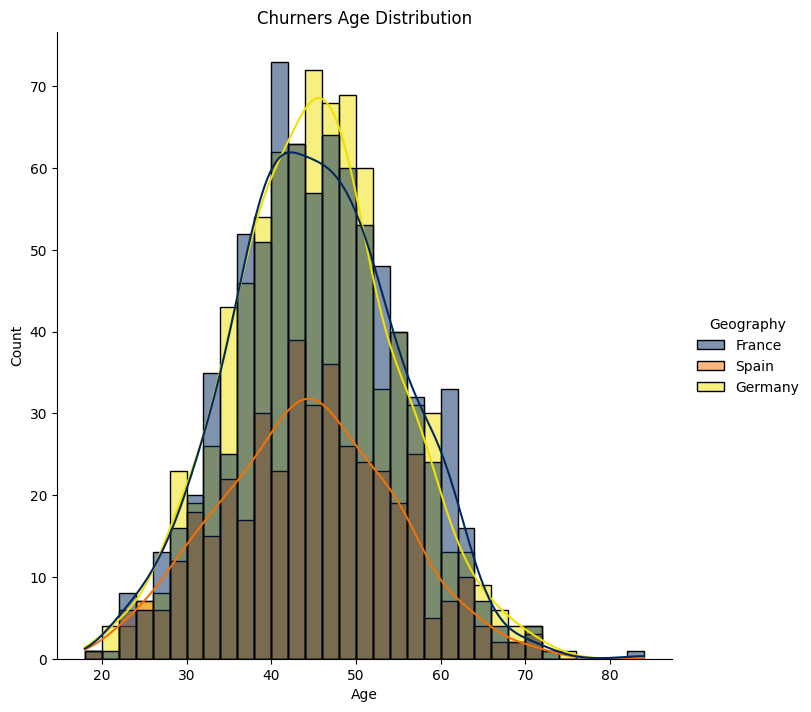

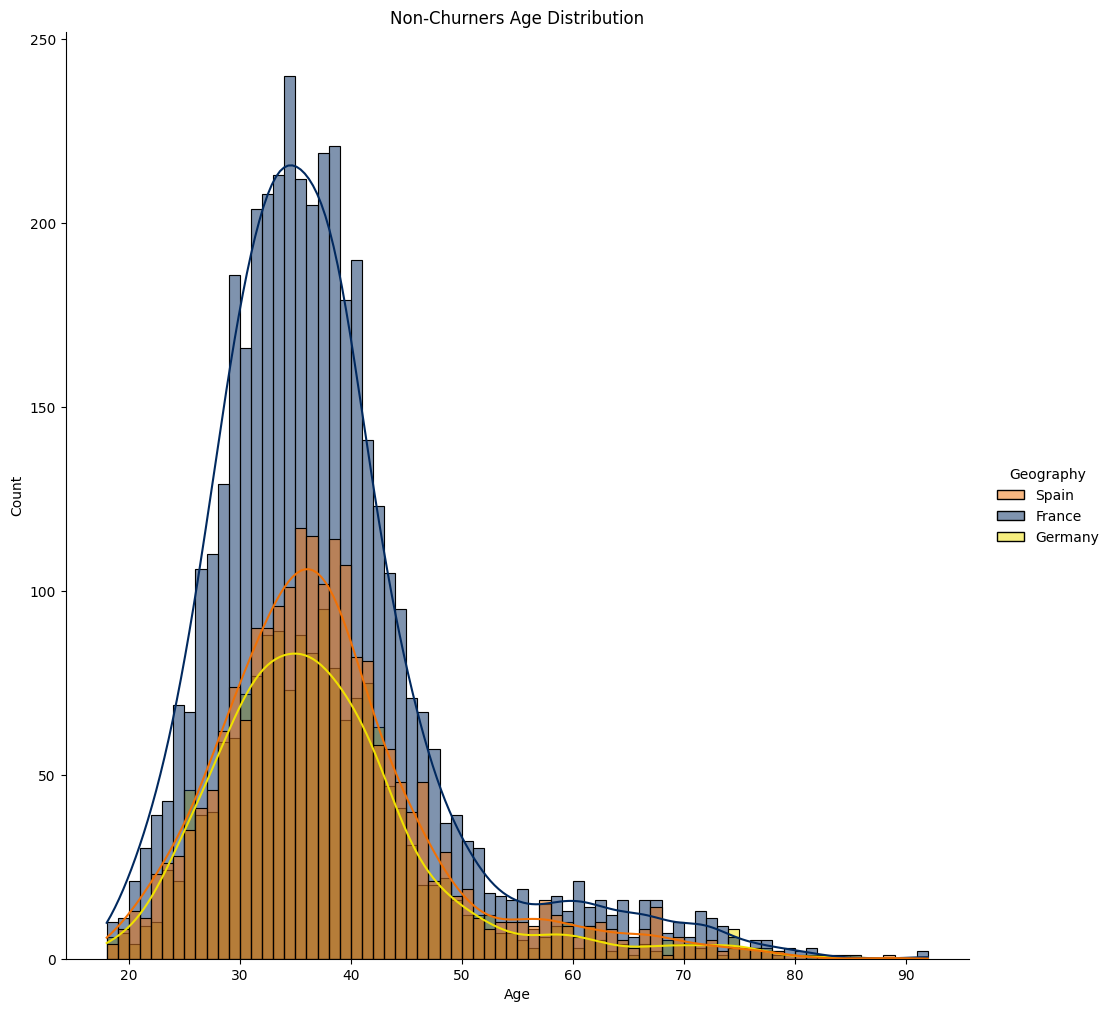

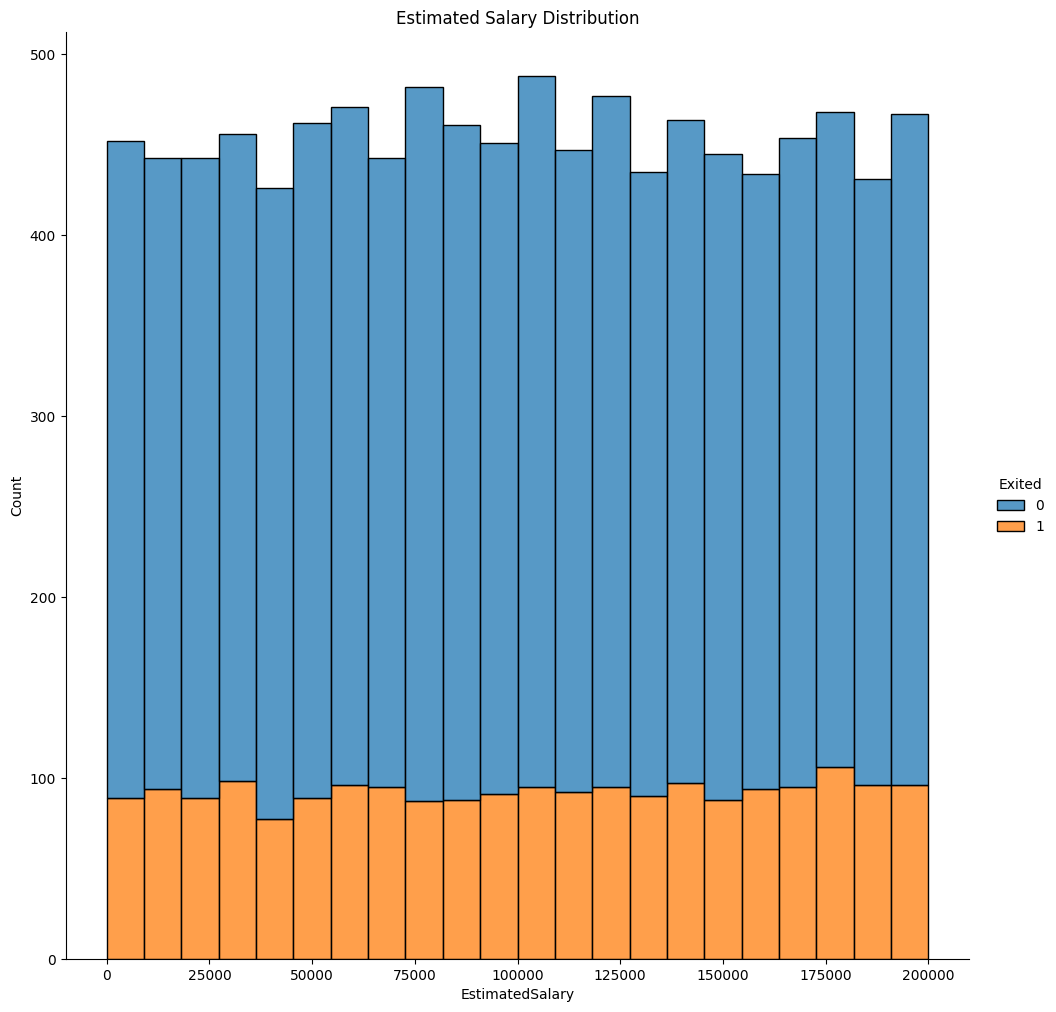

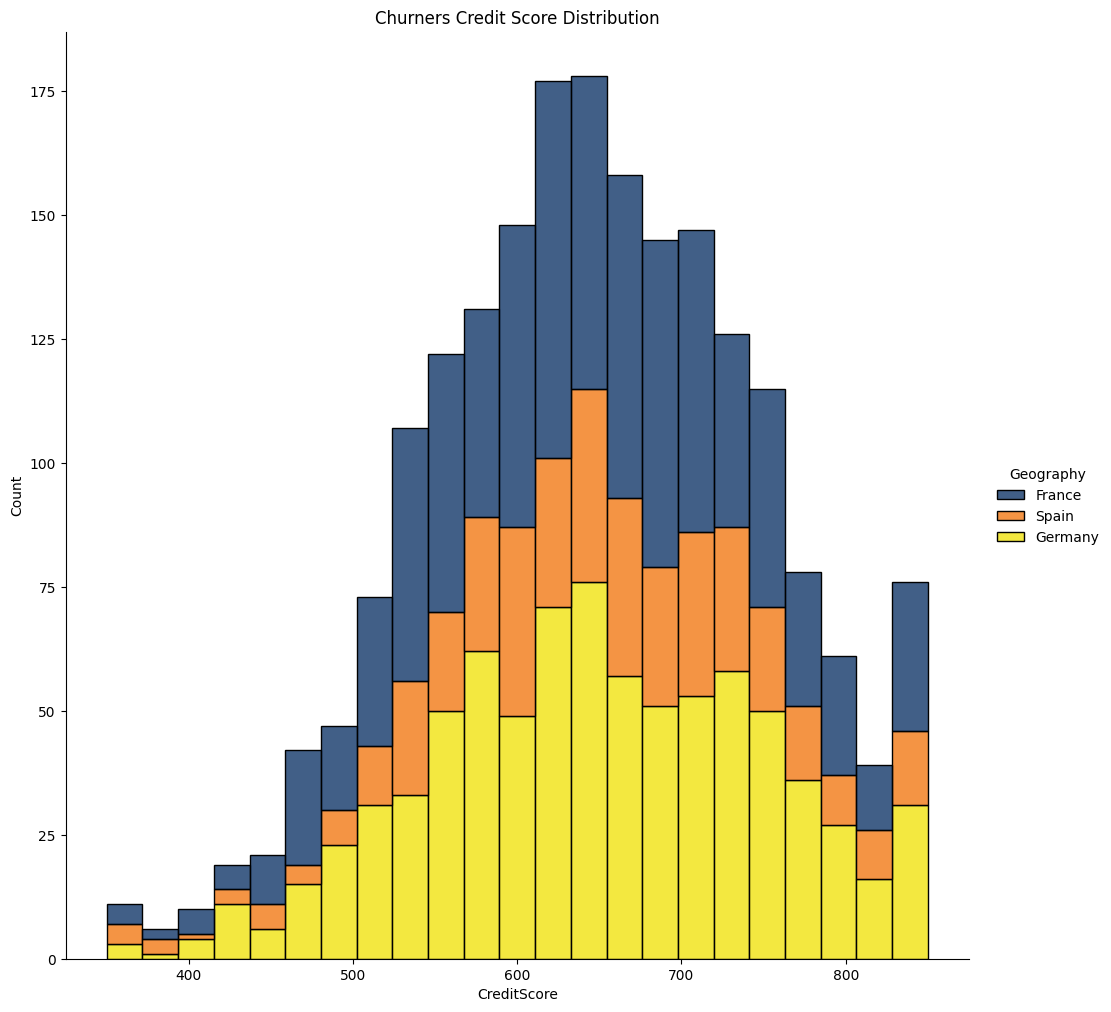

In [5]:
sns.displot(data=churners, x="Age", hue='Geography', kde=True, height=7, palette=palette).set(title='Churners Age Distribution')
sns.displot(data=nonchurners, x="Age", hue='Geography', kde=True, height=10, palette=palette).set(title='Non-Churners Age Distribution')
sns.displot(df_churn, x="EstimatedSalary", hue="Exited", multiple="stack", height=10).set(title='Estimated Salary Distribution')
sns.displot(churners, x="CreditScore", hue="Geography", multiple="stack", height=10, palette=palette).set(title='Churners Credit Score Distribution')
balance_df=pd.DataFrame(df_churn['Exited'].value_counts(normalize=False))
balance_df=balance_df.reset_index().rename(columns = {'index':'Exited','Exited':'Count'})
balance_df

In [6]:
df_churn.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


# Preprocessing

In [7]:
df_churn = pd.get_dummies(df_churn, columns=['Geography'])

In [50]:
X = df_churn.drop(['Exited'], axis=1)
y = df_churn['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5134)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5134)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(6375,)
(2125,)
(1500,)


# Model

**TODO: CROSS VALIDATION**

Accuracy: 0.868
F1 Score: 0.5975609756097561
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1603
           1       0.76      0.49      0.60       397

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



Text(70.72222222222221, 0.5, 'Actual')

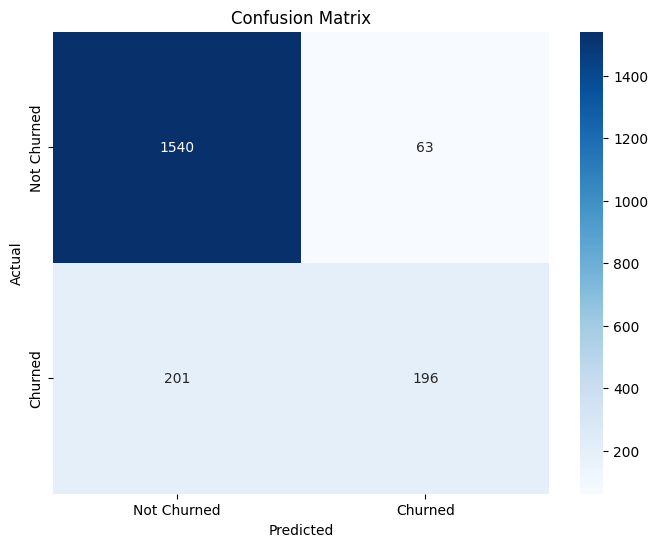

In [9]:
# Random Forest Classifier
rf = RandomForestClassifier(criterion='gini', n_estimators=100, random_state=5134)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Not Churned', 'Churned'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

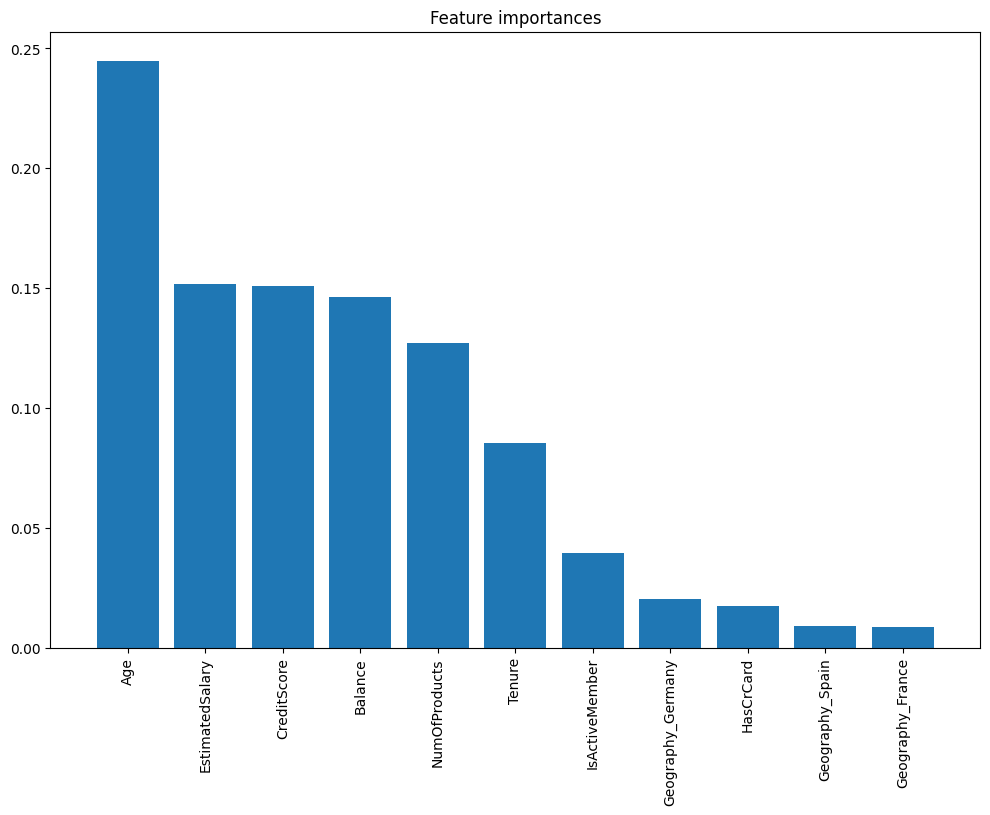

In [ ]:
# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

**TODO: CROSS VALIDATION**

Accuracy: 0.8695
F1 Score: 0.5902668759811617
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1603
           1       0.78      0.47      0.59       397

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



Text(70.72222222222221, 0.5, 'Actual')

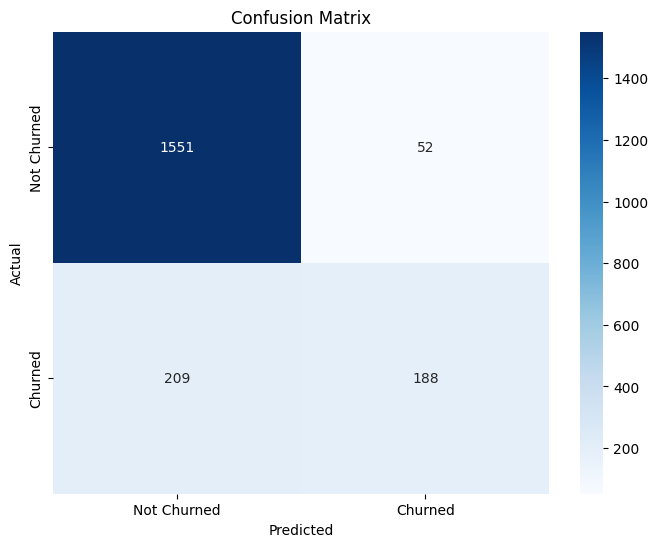

In [10]:
# XGBoost Classifier
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=5134)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Not Churned', 'Churned'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [52]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [66]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [56]:
# Neural Network Classifier
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [57]:
# Initialize the model
input_size = df_churn.shape[1] - 1  # Number of features
hidden_size = 50  # Number of hidden units
num_classes = 2
model = SimpleNN(input_size, hidden_size, num_classes)

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.7201
Epoch [2/10], Loss: 0.1730
Epoch [3/10], Loss: 0.4055
Epoch [4/10], Loss: 0.1942
Epoch [5/10], Loss: 0.1018
Epoch [6/10], Loss: 0.4429
Epoch [7/10], Loss: 0.4752
Epoch [8/10], Loss: 0.3332
Epoch [9/10], Loss: 0.3061
Epoch [10/10], Loss: 0.0867


In [67]:
# Initialize the model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, targets in val_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch [1/100], Training Loss: 0.5494, Validation Loss: 0.4227
Epoch [2/100], Training Loss: 0.5238, Validation Loss: 0.3898
Epoch [3/100], Training Loss: 0.5222, Validation Loss: 0.3674
Epoch [4/100], Training Loss: 0.5067, Validation Loss: 0.3563
Epoch [5/100], Training Loss: 0.5154, Validation Loss: 0.3450
Epoch [6/100], Training Loss: 0.5123, Validation Loss: 0.3445
Epoch [7/100], Training Loss: 0.5138, Validation Loss: 0.3395
Epoch [8/100], Training Loss: 0.5187, Validation Loss: 0.3378
Epoch [9/100], Training Loss: 0.5329, Validation Loss: 0.3370
Epoch [10/100], Training Loss: 0.5189, Validation Loss: 0.3347
Epoch [11/100], Training Loss: 0.5303, Validation Loss: 0.3358
Epoch [12/100], Training Loss: 0.5371, Validation Loss: 0.3371
Epoch [13/100], Training Loss: 0.5366, Validation Loss: 0.3377
Epoch [14/100], Training Loss: 0.5282, Validation Loss: 0.3352
Epoch [15/100], Training Loss: 0.4954, Validation Loss: 0.3327
Epoch [16/100], Training Loss: 0.5276, Validation Loss: 0.3351
E

Test Accuracy: 0.8753
F1 Score: 0.8606


Text(70.72222222222221, 0.5, 'Actual')

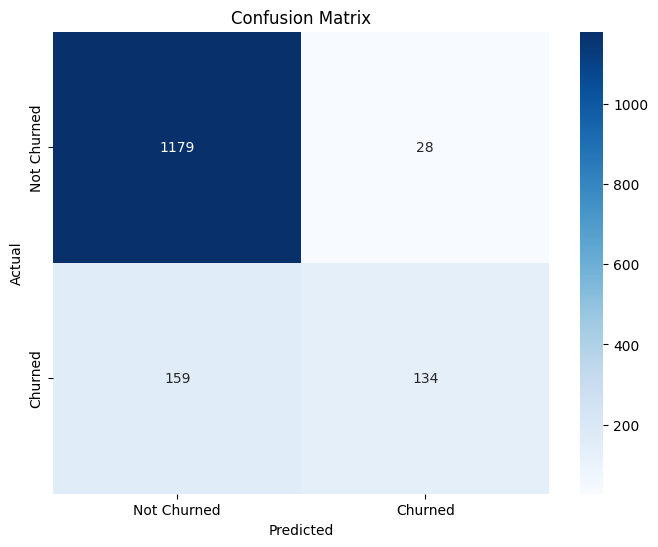

In [68]:
# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = accuracy_score(y_test_tensor, predicted)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1_score(y_test_tensor, predicted, average="weighted"):.4f}')
cm = confusion_matrix(y_test_tensor, predicted)
cm_df = pd.DataFrame(cm, index=['Not Churned', 'Churned'], columns=['Not Churned', 'Churned'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')